In [33]:
import gensim.downloader 
import ast
import pandas as pd
import numpy as np


# Show all available models in gensim-data
print(list(gensim.downloader.info()['models'].keys()))

['fasttext-wiki-news-subwords-300', 'conceptnet-numberbatch-17-06-300', 'word2vec-ruscorpora-300', 'word2vec-google-news-300', 'glove-wiki-gigaword-50', 'glove-wiki-gigaword-100', 'glove-wiki-gigaword-200', 'glove-wiki-gigaword-300', 'glove-twitter-25', 'glove-twitter-50', 'glove-twitter-100', 'glove-twitter-200', '__testing_word2vec-matrix-synopsis']


In [ ]:
def generate_word2vec_features(tokens, type='word2vec-google-news-300', pad_length=None):

    if 'model' not in globals():
        global model
        model = genism.downloader.load(type)

    output_vectors = []
    for word in tokens:
        word_vector = model[word]
        output_vectors.append(word_vector)

    if pad_length is not None:
        while len(output_vectors) < pad_length:
            output_vectors.append(np.zeros(output_vectors[0].shape))

    return np.array(output_vectors)


In [ ]:
def generate_tfidf_features(tokens_array):

    from sklearn.feature_extraction.text import TfidfVectorizer

    content = []
    for post in tokens_array:
        document = ''
        for word in post:
            document = document + ' ' + word

        content.append(document)
    content = np.array(content)

    tf = TfidfVectorizer()
    tfidf_vectors = tf.fit_transform(content)

    return tfidf_vectors

In [34]:
if 'model' not in globals():
    model = gensim.downloader.load('word2vec-google-news-300')

In [35]:
#Read in data and convert tokens to list
INFILE = './data/postprocessed_data_2711.csv'
data = pd.read_csv(INFILE)
data['token_list'] = data['tokens'].apply(lambda x: ast.literal_eval(x))

In [36]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(data['account'])
data['account_label'] = le.transform(data['account'])

In [37]:
data['account_label'].value_counts()

5     63
26    13
25    11
15    10
1      6
19     6
0      6
24     6
27     5
21     5
18     4
3      4
6      4
4      3
16     3
8      3
20     2
22     2
13     2
2      2
10     2
14     1
7      1
12     1
17     1
23     1
11     1
9      1
Name: account_label, dtype: int64

In [38]:
len(data)

169

In [39]:
import time

token_list = data['token_list']

dataset = []
all_word_vecs = []
all_post_indices = []
all_words = []
pad_length = 100

posts = {}

null_list = []
for i, test in enumerate(token_list):

    words = []
    embeddings = []
    nulls = []

    for word in test:
        try:
            vec = model[word]
            embeddings.append(vec)
            all_words.append(word)
            all_word_vecs.append(vec)
            all_post_indices.append(i)
            words.append(word)
        except:
            nulls.append(word)
            #print(word, " is not in the corpus.")

    #while len(embedding_list) < pad_length:
    #    embedding_list.append(np.zeros((300,)))
    embeddings = np.array(embeddings)
    posts[i] = {}
    posts[i]['words'] = words
    posts[i]['vecs'] = embeddings
    posts[i]['nulls'] = nulls
    posts[i]['account'] = data.loc[i, 'account']

    #dataset.append(embedding_list)

dataset = np.array(dataset)
all_post_indices = np.array(all_post_indices)
all_words = np.array(all_words)
#print(null_list)

all_word_vecs = np.array(all_word_vecs)

In [40]:
print(all_words.shape)


(2207,)


In [41]:
print(all_post_indices)

[  0   0   0 ... 168 168 168]


In [42]:
%matplotlib qt
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import matplotlib.cm as cm

stop = 10000

model_tsne = TSNE()
np.set_printoptions(suppress=True)
 
y = model_tsne.fit_transform(all_word_vecs)
condition = np.isin(all_post_indices, [0,1,2,4,5])
Y = y
#Y = y[np.where(condition)]
colors = cm.rainbow(np.linspace(1,max(all_post_indices),1))

plt.scatter(Y[:stop, 0], Y[:stop, 1],alpha=.5, c=colors[:stop])

for i, _ in enumerate(Y):
    word = all_words[i]
    x = Y[:,0]
    y = Y[:,1]
    plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                    textcoords='offset points', ha='right', va='bottom', size=8)
#plt.savefig('plots/word_embeddings_1710.jpg')

C:\Users\jackh\Anaconda3\envs\synther\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\jackh\Anaconda3\envs\synther\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


C:\Users\jackh\Anaconda3\envs\synther\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
C:\Users\jackh\Anaconda3\envs\synther\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
C:\Users\jackh\AppData\Local\Temp/ipykernel_41608/3833560757.py:10: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax = Axes3D(fig)
C:\Users\jackh\AppData\Roaming\Python\Python38\site-packages\matplotlib\collections.py:980: RuntimeWa

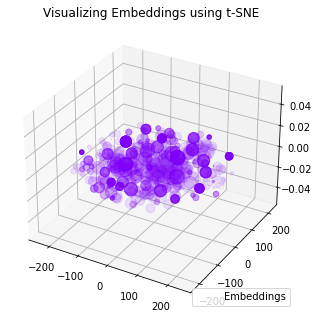

In [43]:
%matplotlib inline
tsne_wp_3d = TSNE(perplexity=30, n_components=3, init='pca', n_iter=3500, random_state=12)
embeddings_wp_3d = tsne_wp_3d.fit_transform(all_word_vecs)

from mpl_toolkits.mplot3d import Axes3D


def tsne_plot_3d(title, label, embeddings, a=1):
    fig = plt.figure()
    ax = Axes3D(fig)
    colors = cm.rainbow(np.linspace(0, 1, 1))
    x = embeddings[:, 0]
    y = embeddings[:, 1]
    z = embeddings[:, 2]
    plt.scatter(x, y, z, c=colors, alpha=a, label=label)

    for i, word in enumerate(all_words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)

    plt.legend(loc=4)
    plt.title(title)
    plt.show()


tsne_plot_3d('Visualizing Embeddings using t-SNE', 'Embeddings', embeddings_wp_3d, a=0.1)

In [44]:
Y.shape

(2207, 2)

In [45]:
'''
from nltk.cluster import KMeansClusterer
import nltk
from sklearn import cluster
from sklearn import metrics

X=vec

NUM_CLUSTERS=5
kclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25 , avoid_empty_clusters=True)
assigned_clusters = kclusterer.cluster(X, assign_clusters=True)

  
#words=list(model.wv.vocab)
#for i, word in enumerate(words):
#print(word +': '+str(assigned_clusters[i]))

kmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)
kmeans.fit(X)
  
labels = kmeans.labels_
centroids = kmeans.cluster_centers_
  
print ("Cluster id labels for inputted data")
print (labels)
print ("Centroids data")
print (centroids)
  
print ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")
print (kmeans.score(X))
  
silhouette_score = metrics.silhouette_score(X, labels, metric='euclidean')
  
print ("Silhouette_score: ")
print (silhouette_score)
'''

'\nfrom nltk.cluster import KMeansClusterer\nimport nltk\nfrom sklearn import cluster\nfrom sklearn import metrics\n\nX=vec\n\nNUM_CLUSTERS=5\nkclusterer = KMeansClusterer(NUM_CLUSTERS, distance=nltk.cluster.util.cosine_distance, repeats=25 , avoid_empty_clusters=True)\nassigned_clusters = kclusterer.cluster(X, assign_clusters=True)\n\n  \n#words=list(model.wv.vocab)\n#for i, word in enumerate(words):\n#print(word +\': \'+str(assigned_clusters[i]))\n\nkmeans = cluster.KMeans(n_clusters=NUM_CLUSTERS)\nkmeans.fit(X)\n  \nlabels = kmeans.labels_\ncentroids = kmeans.cluster_centers_\n  \nprint ("Cluster id labels for inputted data")\nprint (labels)\nprint ("Centroids data")\nprint (centroids)\n  \nprint ("Score (Opposite of the value of X on the K-means objective which is Sum of distances of samples to their closest cluster center):")\nprint (kmeans.score(X))\n  \nsilhouette_score = metrics.silhouette_score(X, labels, metric=\'euclidean\')\n  \nprint ("Silhouette_score: ")\nprint (silhouet

In [46]:
'''
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
 
model_tsne = TSNE(random_state=0)
np.set_printoptions(suppress=True)
 
Y=model_tsne.fit_transform(all_words)
 
 
plt.scatter(Y[:, 0], Y[:, 1],alpha=.5)


print(Y)
 
for j in range(0,len(sent)):    
   plt.annotate(assigned_clusters[j],xy=(Y[j][0], Y[j][1]),xytext=(0,0),textcoords='offset points')
   print("%s %s" % (assigned_clusters[j],  sent[j]))
 
plt.show()
'''

'\nimport matplotlib.pyplot as plt\nfrom sklearn.manifold import TSNE\n \nmodel_tsne = TSNE(random_state=0)\nnp.set_printoptions(suppress=True)\n \nY=model_tsne.fit_transform(all_words)\n \n \nplt.scatter(Y[:, 0], Y[:, 1],alpha=.5)\n\n\nprint(Y)\n \nfor j in range(0,len(sent)):    \n   plt.annotate(assigned_clusters[j],xy=(Y[j][0], Y[j][1]),xytext=(0,0),textcoords=\'offset points\')\n   print("%s %s" % (assigned_clusters[j],  sent[j]))\n \nplt.show()\n'

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer


for i, post in posts.items():
    x = post.get('full_string', '')
    for word in post['words']:
        if x == '':
            x = word
        else:
            x = x + ' ' + word
    post['full_string'] = x

content = [post['full_string'] for post in posts.values()]
content = np.array(content)

#data['tokens_removed_stops']

tf = TfidfVectorizer()

tfidf_vectors = tf.fit_transform(content)
len(tf.get_feature_names_out())

508

In [48]:
tfidf_vectors.shape

(169, 508)

In [49]:
tfidf_vectors = tfidf_vectors.toarray()

In [50]:
unique_labels = data['account_label'].max()

C:\Users\jackh\Anaconda3\envs\synther\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\jackh\Anaconda3\envs\synther\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


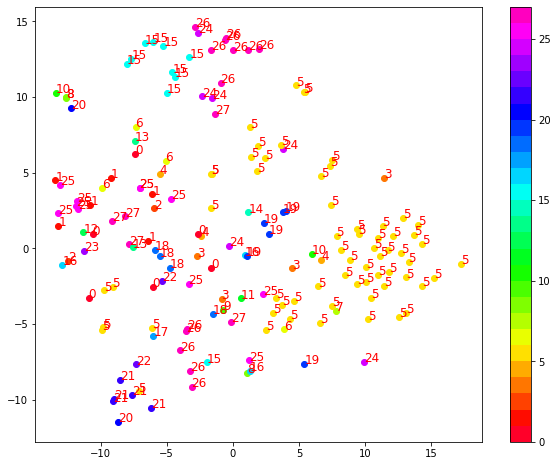

In [51]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
 
model_tsne = TSNE(random_state=0)
np.set_printoptions(suppress=True)
 
initial_tsne=model_tsne.fit_transform(tfidf_vectors)

fig,ax = plt.subplots(figsize=(10,8))
cmap = plt.get_cmap('gist_rainbow', unique_labels)

for i in range(len(initial_tsne)):

    cax = ax.scatter(initial_tsne[i, 0], initial_tsne[i, 1],  c=data.loc[i,'account_label'], cmap=cmap, 
                vmin=0, vmax=unique_labels)
    ax.text(initial_tsne[i, 0], initial_tsne[i, 1], str(data.loc[i,'account_label']), color="red", fontsize=12)

fig.colorbar(cax)#, extend='min')
plt.show()

In [52]:
from sklearn.decomposition import PCA

# reduce the amount of dimensions in the feature vector
pca = PCA(n_components=30, random_state=22)
pca.fit(tfidf_vectors)
pca_vectors = pca.transform(tfidf_vectors)

In [53]:
pca_vectors.shape

(169, 30)

C:\Users\jackh\Anaconda3\envs\synther\lib\site-packages\sklearn\manifold\_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
C:\Users\jackh\Anaconda3\envs\synther\lib\site-packages\sklearn\manifold\_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


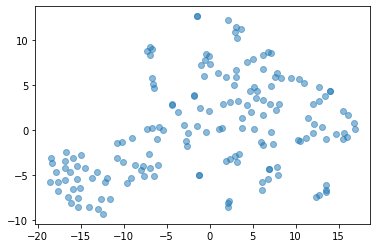

In [54]:
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
 
model_tsne = TSNE(random_state=0)
np.set_printoptions(suppress=True)
 
pca_tsne=model_tsne.fit_transform(pca_vectors)
 
 
plt.scatter(pca_tsne[:, 0], pca_tsne[:, 1],alpha=.5)

In [55]:
pca_tsne.shape

(169, 2)

In [56]:
vectors_to_cluster = pca_tsne

In [57]:
from sklearn.cluster import KMeans

# cluster feature vectors
kmeans = KMeans(n_clusters=unique_labels, random_state=22)
kmeans.fit(vectors_to_cluster)
names = [post['account'] for post in posts.values()]
# holds the cluster id and the images { id: [images] }
groups = {}
for i, cluster in enumerate(kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(i)
    else:
        groups[cluster].append(i)

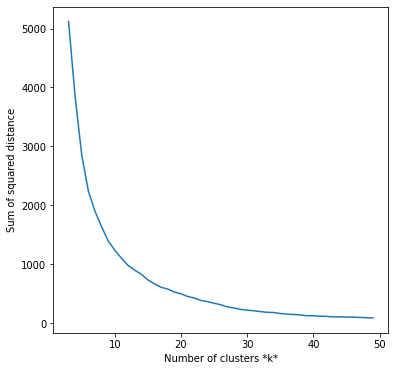

In [58]:
   
# this is just incase you want to see which value for k might be the best 
sse = []
list_k = list(range(3, 50))

for k in list_k:
    km = KMeans(n_clusters=k, random_state=22)
    km.fit(vectors_to_cluster)
    
    sse.append(km.inertia_)

# Plot sse against k
plt.figure(figsize=(6, 6))
plt.plot(list_k, sse)
plt.xlabel(r'Number of clusters *k*')
plt.ylabel('Sum of squared distance');

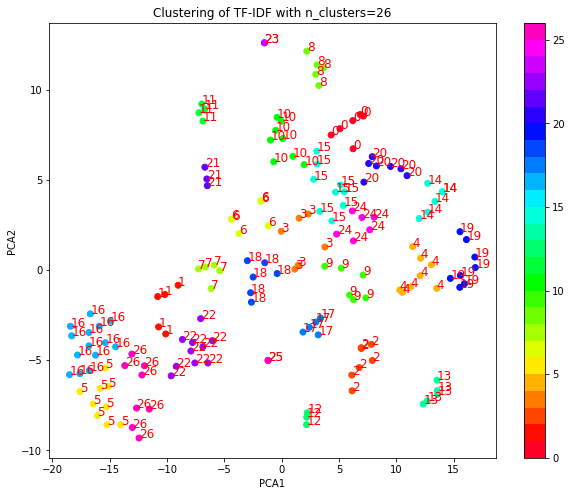

In [59]:
max_keys = np.array(list(groups.keys())).max()
fig,ax = plt.subplots(figsize=(10,8))
cmap = plt.get_cmap('gist_rainbow', max_keys)

for key, indices in groups.items():

    cax = ax.scatter(vectors_to_cluster[indices][:,0], vectors_to_cluster[indices][:,1], c=[key]*len(indices), cmap=cmap, 
                vmin=0, vmax=max_keys)
    for indic in indices:
        ax.text(vectors_to_cluster[indic][0], vectors_to_cluster[indic][1], str(key), color="red", fontsize=12)

plt.title(f'Clustering of TF-IDF with n_clusters={max_keys}')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
fig.colorbar(cax)#, extend='min')
plt.savefig('plots/clustering_predictions_pcaTSNE_2811.png')
plt.show()


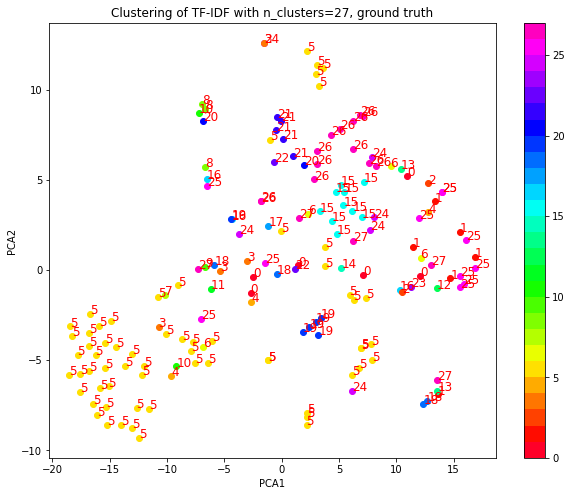

In [60]:
fig,ax = plt.subplots(figsize=(10,8))
cmap = plt.get_cmap('gist_rainbow', unique_labels)

for key, indices in groups.items():
    for post_index in indices:
        key = data.loc[post_index, 'account_label']

        cax = ax.scatter(vectors_to_cluster[post_index][0], vectors_to_cluster[post_index][1], c=key, cmap=cmap, 
                vmin=0, vmax=unique_labels)
        ax.text(vectors_to_cluster[post_index][0], vectors_to_cluster[post_index][1], str(key), color="red", fontsize=12)
    
    

plt.title(f'Clustering of TF-IDF with n_clusters={unique_labels}, ground truth')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
fig.colorbar(cax)#, extend='min')
plt.savefig('plots/clustering_predictions_pcaTSNE-groundtruth_2811.png')
plt.show()